In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wrds
import statsmodels.api as sm

## The Data

In [ ]:
borisovadb=wrds.Connection()

In [ ]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1928-01-01'
            and mcaldt<='2004-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1928-01-01' and date<='2004-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns 
#---------------------------------------------
stock_data = db.raw_sql("""
                    select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1928' and '12/31/2004'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
stock_data = stock_data.rename(columns={'ret':'Rn'})
stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(stock_data, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data.to_csv('data.csv', sep=';',index=False) # export data

In [3]:
data = pd.read_csv('data.csv', sep=';')
data

,permno,date,shrcd,exchcd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10028,1992-06-30,11,2,-0.206897,5632.0,-1.43750,8.096000e+03,NaN,0.002928,-0.019258,1,-0.209825,-0.022186
1,10028,1992-05-29,11,2,-0.205479,5548.0,-1.81250,1.005575e+04,8.096000e+03,0.003030,0.006407,1,-0.208509,0.003377
2,10028,1992-04-30,11,2,-0.170455,5548.0,-2.28125,1.265638e+04,1.005575e+04,0.002920,0.013414,1,-0.173375,0.010494
3,10028,1992-03-31,11,2,0.419355,5548.0,2.75000,1.525700e+04,1.265638e+04,0.003343,-0.023699,1,0.416012,-0.027042
4,10028,1998-05-29,11,2,0.047619,4151.0,2.75000,1.141525e+04,1.525700e+04,0.003806,-0.025746,1,0.043813,-0.029552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439403,92602,2012-09-28,11,1,0.016685,1685722.0,89.94000,1.516138e+08,1.492875e+08,0.000034,0.026513,1,0.016651,0.026479
1439404,92602,2012-08-31,11,1,-0.023403,1685722.0,89.30000,1.505350e+08,1.516138e+08,0.000065,0.026317,1,-0.023468,0.026252
1439405,92602,2012-07-31,11,1,0.047903,1705563.0,91.44000,1.559567e+08,1.505350e+08,0.000051,0.010307,1,0.047852,0.010256
1439406,92602,2012-06-29,11,1,0.041652,1705563.0,87.26000,1.488274e+08,1.559567e+08,0.000030,0.038151,1,0.041622,0.038121


In [62]:
data=data.sort_values(['permno','date']).reset_index(drop=True)

## Betting against Beta strategy (BaB)

### Time-varying market Beta 

In [63]:
data = data.drop(columns='beta')

In [64]:
window_size = 60

if 'beta' not in data.columns:
    data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
    data['N'] = data.groupby(['permno'])['date'].transform('count')
    data = data[data['N']>60].copy()

    cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window_size, min_periods=36).cov()
    beta = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
    beta = beta.dropna()
    beta = beta.reset_index().rename(columns={'Rm_e': 'beta'})

    beta['date'] = pd.to_datetime(beta['date'])
    beta['date'] = beta['date'] + pd.DateOffset(months=1)
    beta['date'] = beta['date'].dt.strftime('%Y-%m-%d')
    data = pd.merge(data, beta, on=['date','permno'], how='left')

    
    data['beta'] = data['beta'].clip(lower = data['beta'].quantile(0.05), upper = data['beta'].quantile(0.95))

In [65]:
data

,permno,date,shrcd,exchcd,Rn,shrout,prc,mcap,mcap_l,rf,...,z_mean,z_,k,w_H,w_L,beta_H,beta_L,R_H_e,R_L_e,beta
0,10006,1964-04-30,10,1,0.003636,2948.0,69.00000,2.034120e+05,1.997270e+05,0.002797,...,666.0,99.0,0.000005,0.000447,-0.000000,0.000626,-0.000000,3.751242e-07,-0.000000,NaN
1,10006,1964-08-31,10,1,0.012780,2948.0,78.62500,2.317865e+05,2.491060e+05,0.002720,...,674.5,89.5,0.000004,0.000394,-0.000000,0.000553,-0.000000,3.963980e-06,-0.000000,NaN
2,10006,1964-09-30,10,1,0.074722,2948.0,84.50000,2.491060e+05,2.564760e+05,0.002936,...,677.5,77.5,0.000004,0.000338,-0.000000,0.000470,-0.000000,2.427688e-05,-0.000000,NaN
3,10006,1964-10-30,10,1,0.029586,2948.0,87.00000,2.564760e+05,2.483690e+05,0.002856,...,677.5,86.5,0.000004,0.000377,-0.000000,0.000530,-0.000000,1.008956e-05,-0.000000,NaN
4,10006,1964-11-30,10,1,-0.023276,2948.0,84.25000,2.483690e+05,2.359560e+05,0.002979,...,681.5,62.5,0.000004,0.000270,-0.000000,0.000372,-0.000000,-7.076544e-06,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298130,92655,2022-12-30,11,1,-0.029082,934349.0,530.17999,4.953731e+08,4.664177e+08,0.003326,...,495.0,-473.5,0.000008,-0.000000,0.003873,-0.000000,0.000998,0.000000e+00,-0.000126,0.693926
298131,92655,2023-02-28,11,1,-0.046576,932847.0,475.94000,4.439792e+08,4.408542e+08,0.003682,...,493.0,-472.5,0.000008,-0.000000,0.003896,-0.000000,0.001004,0.000000e+00,-0.000196,NaN
298132,92655,2023-06-30,11,1,-0.009687,931032.0,480.64001,4.474912e+08,4.714467e+08,0.004302,...,494.5,-474.5,0.000008,-0.000000,0.003889,-0.000000,0.001002,0.000000e+00,-0.000054,NaN
298133,92655,2023-08-31,11,1,-0.058831,926305.0,476.57999,4.414584e+08,4.670337e+08,0.004463,...,490.0,-470.5,0.000008,-0.000000,0.003927,-0.000000,0.001012,0.000000e+00,-0.000249,NaN


### Portfolio Sorts
#### Equall Weighted

In [66]:
data = data.dropna(subset='beta').copy()
data['beta_decile'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))
data['ew_decile'] = 1 / data.groupby(['date','beta_decile'])['permno'].transform('count')
data['ew_decile_ret'] = data['ew_decile'] * data['Rn']
data['ew_decile_excess_ret'] = data['ew_decile'] * data['Rn_e']
ret_ew = data.groupby(['date','beta_decile'])['ew_decile_ret'].sum().reset_index()
ew_decile_excess_ret = data.groupby(['date', 'beta_decile'])['ew_decile_excess_ret'].sum().reset_index(name='ew_decile_excess_ret')
ret_ew = ret_ew.merge(ew_decile_excess_ret, on=['date', 'beta_decile'])
ret_ew

,date,beta_decile,ew_decile_ret,ew_decile_excess_ret
0,1974-02-28,0,0.079573,0.073426
1,1974-02-28,1,-0.057619,-0.063767
2,1974-02-28,2,0.027027,0.020880
3,1974-02-28,3,0.004724,-0.001423
4,1974-02-28,4,-0.090035,-0.096182
...,...,...,...,...
647,2022-12-30,5,-0.037141,-0.040467
648,2022-12-30,6,-0.048662,-0.051988
649,2022-12-30,7,-0.054308,-0.057634
650,2022-12-30,8,-0.064312,-0.067638


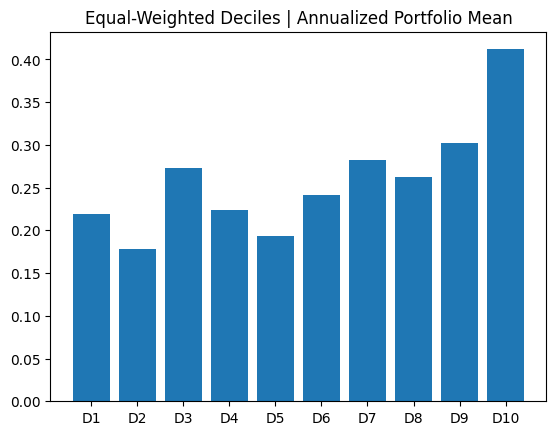

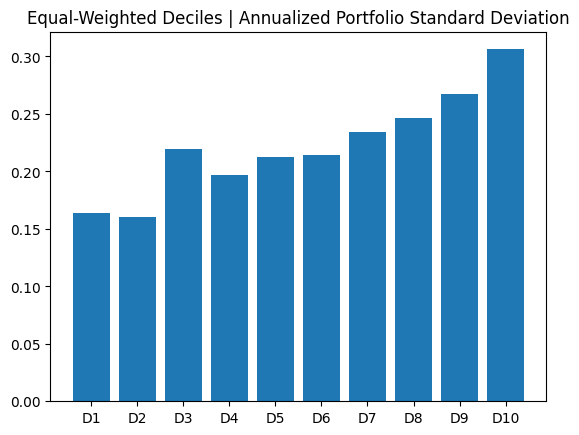

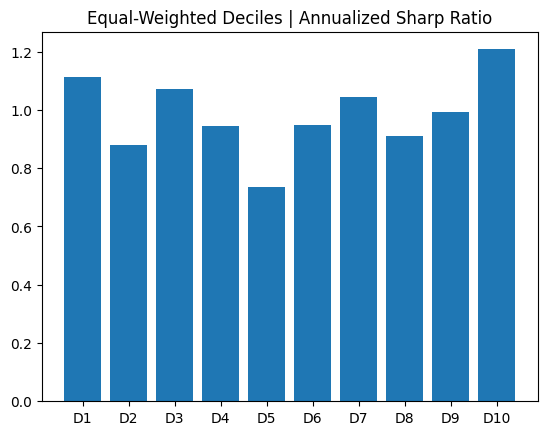

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [67]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew.groupby('beta_decile')['ew_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [68]:
data = data.dropna(subset='beta').copy()
data['beta_decile'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))
data['vw_decile'] = data['mcap'] / data.groupby(['date','beta_decile'])['mcap'].transform('sum')
data['vw_decile_ret'] = data['vw_decile'] * data['Rn']
data['vw_decile_excess_ret'] = data['vw_decile'] * data['Rn_e']
ret_vw = data.groupby(['date','beta_decile'])['vw_decile_ret'].sum().reset_index()
vw_decile_excess_ret = data.groupby(['date', 'beta_decile'])['vw_decile_excess_ret'].sum().reset_index(name='vw_decile_excess_ret')
ret_vw = ret_vw.merge(vw_decile_excess_ret, on=['date', 'beta_decile'])
ret_vw

,date,beta_decile,vw_decile_ret,vw_decile_excess_ret
0,1974-02-28,0,0.045213,0.039066
1,1974-02-28,1,-0.026994,-0.033141
2,1974-02-28,2,0.027027,0.020880
3,1974-02-28,3,-0.075088,-0.081235
4,1974-02-28,4,-0.101144,-0.107291
...,...,...,...,...
647,2022-12-30,5,-0.028525,-0.031851
648,2022-12-30,6,-0.050517,-0.053843
649,2022-12-30,7,-0.062694,-0.066020
650,2022-12-30,8,-0.057775,-0.061101


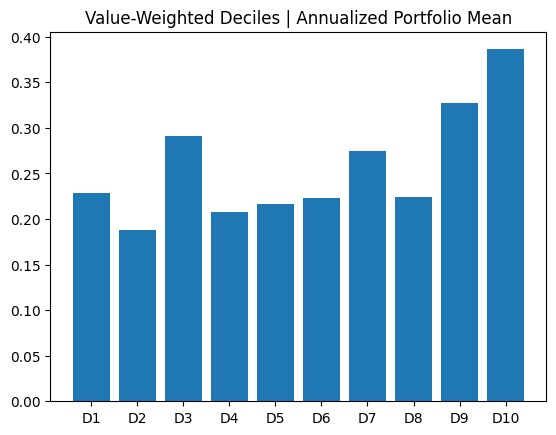

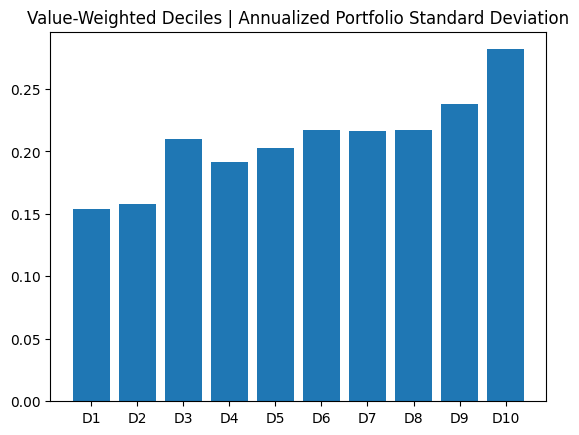

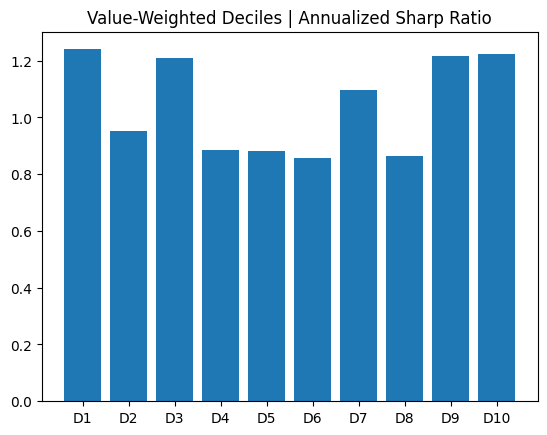

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [69]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw.groupby('beta_decile')['vw_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Constructing the BAB factor

In [70]:
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_mean'] = data.groupby('date')['z'].transform('mean')
data['z_'] = data['z'] - data['z_mean']
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0) 

In [71]:
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']
BAB = data.groupby('date')[['R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()

BAB['R_BAB'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H'] 


In [73]:
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1
tmp = tmp.dropna()
reg = sm.OLS(tmp['R_BAB'], tmp[['const', 'Rm_e']]).fit()

print('----------------------------------------')
print(f"| Annualized mean          | {np.round(tmp['R_BAB'].mean() * 12, 5)}  |")
print(f"| Annualized std           | {np.round(tmp['R_BAB'].std() * np.sqrt(12), 5)}  |")
print(f"| Annualized Sharp Ratio   | {np.round(tmp['R_BAB'].mean() / tmp['R_BAB'].std() * np.sqrt(12), 5)}  |")
print(f"| Annualized CAPM alpha    | {np.round(reg.params['const'] * 12, 5)}  |")
print(f"| BAB factor               | {np.round(reg.params['Rm_e'], 5)} |")
print('----------------------------------------')

----------------------------------------
| Annualized mean          | 0.13718  |
| Annualized std           | 0.13742  |
| Annualized Sharp Ratio   | 0.99822  |
| Annualized CAPM alpha    | 0.05983  |
| BAB factor               | 0.50332 |
----------------------------------------


## Momentum Strategy (Mom)

### Portfolio Sorts

In [80]:
data['lagged_11_month_ret'] = data.groupby('permno')['Rn'].rolling(window=11).apply(lambda x: (1 + x).prod() - 1).reset_index(level=0, drop=True)
data = data.dropna(subset=['lagged_11_month_ret']).copy()
data['lagged_11_month_ret_decile'] = data.groupby('date')['lagged_11_month_ret'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

/var/folders/g_/qfngn4yn24nglz5s9217l2v00000gn/T/ipykernel_8956/528829825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lagged_11_month_ret'] = data.groupby('permno')['Rn'].rolling(window=11).apply(lambda x: (1 + x).prod() - 1).reset_index(level=0, drop=True)


#### Equally Weighted 

In [81]:
data['ew_lagged_decile'] = 1 / data.groupby(['date','lagged_11_month_ret_decile'])['permno'].transform('count')
data['ew_lagged_decile_ret'] = data['ew_lagged_decile'] * data['Rn']
data['ew_lagged_decile_excess_ret'] = data['ew_lagged_decile'] * data['Rn_e']
ret_ew_lagged = data.groupby(['date','lagged_11_month_ret_decile'])['ew_lagged_decile_ret'].sum().reset_index()
ew_lagged_decile_excess_ret = data.groupby(['date', 'lagged_11_month_ret_decile'])['ew_lagged_decile_excess_ret'].sum().reset_index(name='ew_lagged_decile_excess_ret')
ret_ew_lagged = ret_ew_lagged.merge(ew_lagged_decile_excess_ret, on=['date', 'lagged_11_month_ret_decile'])
ret_ew_lagged

,date,lagged_11_month_ret_decile,ew_lagged_decile_ret,ew_lagged_decile_excess_ret
0,1987-11-30,0,-0.162132,-0.165060
1,1987-11-30,1,-0.122642,-0.125570
2,1987-11-30,2,-0.154930,-0.157858
3,1987-11-30,3,-0.150464,-0.153392
4,1987-11-30,4,-0.009884,-0.012811
...,...,...,...,...
465,2022-12-30,5,-0.030940,-0.034267
466,2022-12-30,6,-0.033961,-0.037287
467,2022-12-30,7,-0.039967,-0.043293
468,2022-12-30,8,-0.023629,-0.026955


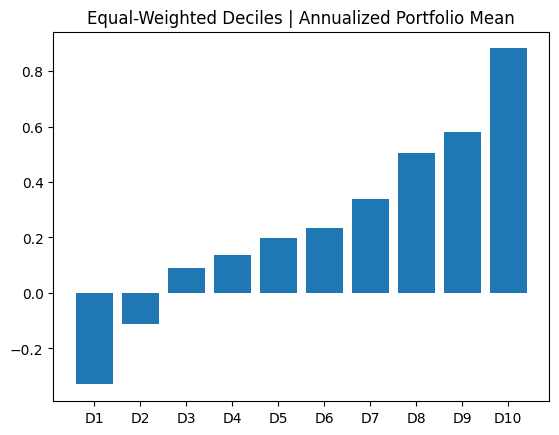

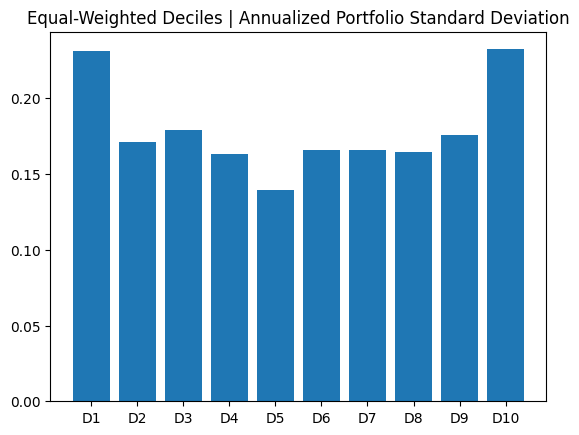

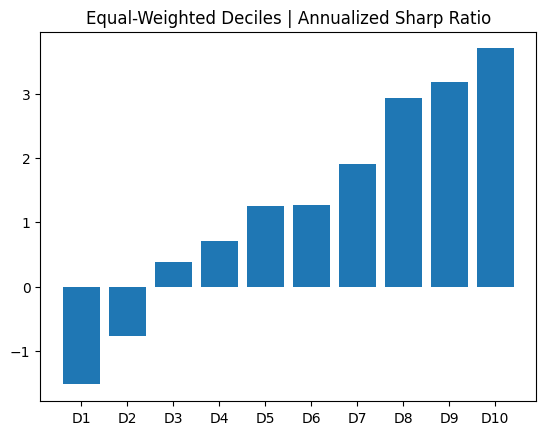

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [82]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()